# TF-GAN

## Hand-Written Digits


A GAN is built and trained to generate Hand-Written Digits. We will use MNIST Dataset to achieve this Task.

### Importing Libraries and Data Preliminaries

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
!pip install tensorflow-gan
import tensorflow_gan as tfgan
from keras.datasets.mnist import load_data
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D,Conv2DTranspose,BatchNormalization,LeakyReLU,Flatten,Activation

TensorFlow 2.x selected.
     |████████████████████████████████| 368kB 3.0MB/s 



Using TensorFlow backend.


In [2]:
(X_train,Y_train), (X_test,Y_test) = load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
X_Train = np.expand_dims(X_train,axis=-1)/255.0
X_Test = np.expand_dims(X_test,axis=-1)/255.0
print (X_Train.shape,Y_train.shape)
print (X_Test.shape,Y_test.shape)

Data = np.append(X_Train,X_Test,axis=0)
print (Data.shape)

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)
(70000, 28, 28, 1)


### Visualising Images

Plotting first 25 Images

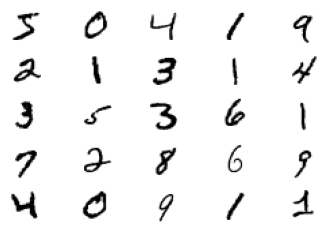

In [4]:
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(X_train[i], cmap='gray_r')
plt.show()

## Generative Adversarial Network (GAN)

Generative Modeling is an Unsupervised Learning task in Machine Learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.

A GAN consists of 2 Neural Networks.
1.   Generator
2.   Discriminator

![GAN](https://www.researchgate.net/publication/335199153/figure/fig1/AS:792329124339712@1565917392960/Architecture-of-the-GAN-22.ppm)

Generator tries to **Create Fake Data** from Random Inputs(Incase of some GANs), whereas a Discriminator tries to **Detect between Fake Data and Real Data**. The Architectures of GANs differ by tasks. The following architectures of Generator and Discriminator are standard ones for generation of Hand-Written Digits Task.




### Discriminator

In [0]:
def Discriminator():
    Input_Discriminator = Input(shape=(28,28,1),dtype=tf.float64)
    x = Conv2D(64,kernel_size=(4,4),strides=(2,2),activation=None, padding='same',kernel_initializer=tf.keras.initializers.glorot_uniform,kernel_regularizer=tf.keras.regularizers.l2(l=2.5e-5),bias_regularizer=tf.keras.regularizers.l2(l=2.5e-5))(Input_Discriminator)
    x = LeakyReLU(alpha=0.01)(x)
    x = Conv2D(128,kernel_size=(4,4),strides=(2,2),activation=None, padding='same',kernel_initializer=tf.keras.initializers.glorot_uniform,kernel_regularizer=tf.keras.regularizers.l2(l=2.5e-5),bias_regularizer=tf.keras.regularizers.l2(l=2.5e-5))(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Flatten()(x)
    x = Dense(1024,None,kernel_initializer=tf.keras.initializers.glorot_uniform,kernel_regularizer=tf.keras.regularizers.l2(l=2.5e-5),bias_regularizer=tf.keras.regularizers.l2(l=2.5e-5))(x)
    x = BatchNormalization(momentum=0.999, epsilon=0.001, trainable=True)(x)
    x = LeakyReLU(alpha=0.01)(x)
    Output_Discriminator = Dense(1,None,kernel_initializer=tf.keras.initializers.glorot_uniform,kernel_regularizer=tf.keras.regularizers.l2(l=2.5e-5),bias_regularizer=tf.keras.regularizers.l2(l=2.5e-5))(x)

    Model_ = Model(inputs=Input_Discriminator,outputs=Output_Discriminator)
    plot_model(Model_, to_file='Discriminator.png', show_shapes=True, show_layer_names=True)

    return Model_    

### Generator

In [0]:
def Generator(Latent_Dims):
    Input_ = Input(shape=(Latent_Dims,),dtype=tf.float64)
    x = Dense(1024,None,kernel_initializer=tf.keras.initializers.glorot_uniform,kernel_regularizer=tf.keras.regularizers.l2(l=2.5e-5),bias_regularizer=tf.keras.regularizers.l2(l=2.5e-5))(Input_)
    x = BatchNormalization(momentum=0.999, epsilon=0.001, trainable=True)(x)
    x = Activation('relu')(x)

    x = Dense(7*7*256,None,kernel_initializer=tf.keras.initializers.glorot_uniform,kernel_regularizer=tf.keras.regularizers.l2(l=2.5e-5),bias_regularizer=tf.keras.regularizers.l2(l=2.5e-5))(x)
    x = BatchNormalization(momentum=0.999, epsilon=0.001, trainable=True)(x)
    x = Activation('relu')(x)

    x = tf.reshape(x,[-1,7,7,256])
    x = Conv2DTranspose(64,kernel_size=(4,4),strides=(2,2),activation=None, padding='same',kernel_initializer=tf.keras.initializers.glorot_uniform,kernel_regularizer=tf.keras.regularizers.l2(l=2.5e-5),bias_regularizer=tf.keras.regularizers.l2(l=2.5e-5))(x)
    x = Conv2DTranspose(64,kernel_size=(4,4),strides=(2,2),activation=None, padding='same',kernel_initializer=tf.keras.initializers.glorot_uniform,kernel_regularizer=tf.keras.regularizers.l2(l=2.5e-5),bias_regularizer=tf.keras.regularizers.l2(l=2.5e-5))(x)
    x = Conv2D(1,1,(1,1))(x)
    Output_ = Activation('tanh')(x)

    Model_ = Model(inputs=Input_,outputs=Output_)
    plot_model(Model_, to_file='Generator.png', show_shapes=True, show_layer_names=True)
    
    return Model_

## Loss Functions

We are using Wasserstein Loss to update weights of GAN.

In [0]:
def Discriminator_Loss(true,fake,D_Model):
    Loss = D_Model(fake) - D_Model(true)
    return tf.reduce_mean(Loss)

In [0]:
def Generator_Loss(true,fake,D_Model):
    Loss = -D_Model(fake)
    return tf.reduce_mean(Loss)

## Training GAN

In [9]:
# Hyperparameters
batch_size=128
Latent_Dims=64
Learning_Rate=0.000001
Epochs = 10000
Optimizer = tf.keras.optimizers.Adam(Learning_Rate)

# Clearing Back-End Models
tf.keras.backend.clear_session()

# Calling Models
D_Model = Discriminator()
G_Model = Generator(Latent_Dims)

D_Model.summary()
G_Model.summary()


# A TensorFlow Function to Train a GAN
@tf.function
def Training_GAN(Real,Batch_Size,Latent_Dims):
    
    # Generator
    with tf.GradientTape() as tape:
        G_Input = tf.random.normal(shape=(Batch_Size,Latent_Dims))
        G_Output = G_Model(G_Input)

        D_Output = D_Model(G_Output)
        G_Loss = Generator_Loss(Real,G_Output,D_Model)

    grads = tape.gradient(G_Loss, G_Model.trainable_variables)
    Optimizer.apply_gradients(zip(grads, G_Model.trainable_variables))

    # Discriminator
    with tf.GradientTape() as tape:
        G_Input = tf.random.normal(shape=(Batch_Size,Latent_Dims))
        G_Output = G_Model(G_Input)

        D_Output = D_Model(G_Output)
        D_Loss = Discriminator_Loss(Real,G_Output,D_Model)

    grads = tape.gradient(D_Loss, D_Model.trainable_variables)
    Optimizer.apply_gradients(zip(grads, D_Model.trainable_variables))

    return G_Loss,D_Loss
    


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Model: "model"
_

In [10]:
Loss_G = []
Loss_D = []

def Input_Generator(X_Train,Batch_Size):
    ind = np.random.randint(0,X_Train.shape[0],Batch_Size)
    Output = []
    for i in ind:
        Output.append(X_Train[i])
    return np.array(Output)

for e in range(Epochs):
    g,d = Training_GAN(tf.convert_to_tensor(Input_Generator(Data,batch_size)),batch_size,Latent_Dims)
    Loss_G.append(g)
    Loss_D.append(d)
    print ("Epoch: {0:5} ;         Generator Loss = {1} ;          Discriminator Loss = {2}".format(e,g,d))

Loss_G = np.array(Loss_G)
Loss_D = np.array(Loss_D)

Streaming output truncated to the last 5000 lines.
Epoch:  5001 ;         Generator Loss = -0.3675476908683777 ;          Discriminator Loss = -0.9145243167877197
Epoch:  5002 ;         Generator Loss = -0.368613600730896 ;          Discriminator Loss = -0.9597172737121582
Epoch:  5003 ;         Generator Loss = -0.36882081627845764 ;          Discriminator Loss = -0.9738324880599976
Epoch:  5004 ;         Generator Loss = -0.3678343892097473 ;          Discriminator Loss = -0.9951176643371582
Epoch:  5005 ;         Generator Loss = -0.3673172891139984 ;          Discriminator Loss = -0.9965445399284363
Epoch:  5006 ;         Generator Loss = -0.3684062659740448 ;          Discriminator Loss = -0.9462958574295044
Epoch:  5007 ;         Generator Loss = -0.36764949560165405 ;          Discriminator Loss = -0.9581054449081421
Epoch:  5008 ;         Generator Loss = -0.3716773986816406 ;          Discriminator Loss = -0.9860086441040039
Epoch:  5009 ;         Generator Loss = -0.365910530

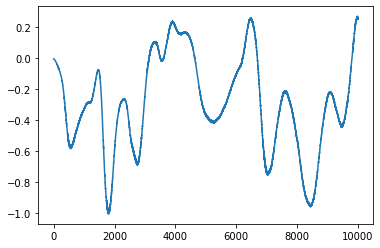

In [11]:
plt.plot(Loss_G.flatten())
plt.show()

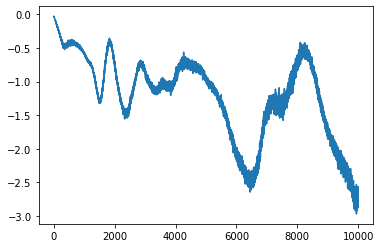

In [12]:
plt.plot(Loss_D.flatten())
plt.show()

## Testing GAN

In [0]:
G_Input = np.random.normal(size=(1,Latent_Dims))
G_Output = G_Model(G_Input)

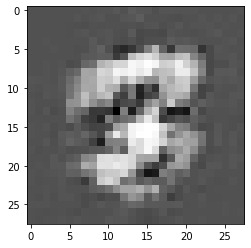

In [14]:
plt.imshow(G_Output[0,:,:,0],cmap='gray')
plt.show()